# Explore here

# Predicting the cost of health insurance for a person

In [3]:
import logging 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ( train_test_split, GridSearchCV ) 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import ( MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder ) 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ( 
        accuracy_score, 
        f1_score, 
        matthews_corrcoef, 
        classification_report, 
        ConfusionMatrixDisplay ) 
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [4]:
# https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv
url = ('https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv')
df_raw = pd.read_csv(url, sep=',')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df_raw.sample(10, random_state=2025)

,age,sex,bmi,children,smoker,region,charges
1269,45,male,27.500,3,no,southwest,8615.30000
942,18,female,40.185,0,no,northeast,2217.46915
1240,52,male,41.800,2,yes,southeast,47269.85400
1229,58,male,30.305,0,no,northeast,11938.25595
272,41,male,37.050,2,no,northwest,7265.70250
738,23,male,31.730,3,yes,northeast,36189.10170
1105,54,female,31.240,0,no,southeast,10338.93160
1182,25,female,30.300,0,no,southwest,2632.99200
14,27,male,42.130,0,yes,southeast,39611.75770
596,42,female,29.480,2,no,southeast,7640.30920


### **2. Data preprocessing** **Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [6]:
df_baking = df_raw.copy()
df_baking['sex'] = df_baking['sex'].astype('category')
df_baking['smoker'] = df_baking['smoker'].astype('category')
df_baking['region'] = df_baking['region'].astype('category')
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


### **3. Exploratory Data Analysis** **Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [7]:
df_train, df_test = train_test_split(
    df, test_size=0.2,
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_test.shape

((1070, 7), (268, 7))

In [14]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.170093,14.174347,18.0000,26.000000,39.000000,51.00000,64.00000
bmi,1070.0,30.704542,6.113250,16.8150,26.315000,30.400000,34.69375,53.13000
children,1070.0,1.077570,1.200468,0.0000,0.000000,1.000000,2.00000,5.00000
charges,1070.0,13293.266695,12119.240247,1121.8739,4740.464375,9296.016525,16746.65740,63770.42801


,count,unique,top,freq
sex,1070,2,female,541
smoker,1070,2,no,850
region,1070,4,southeast,286


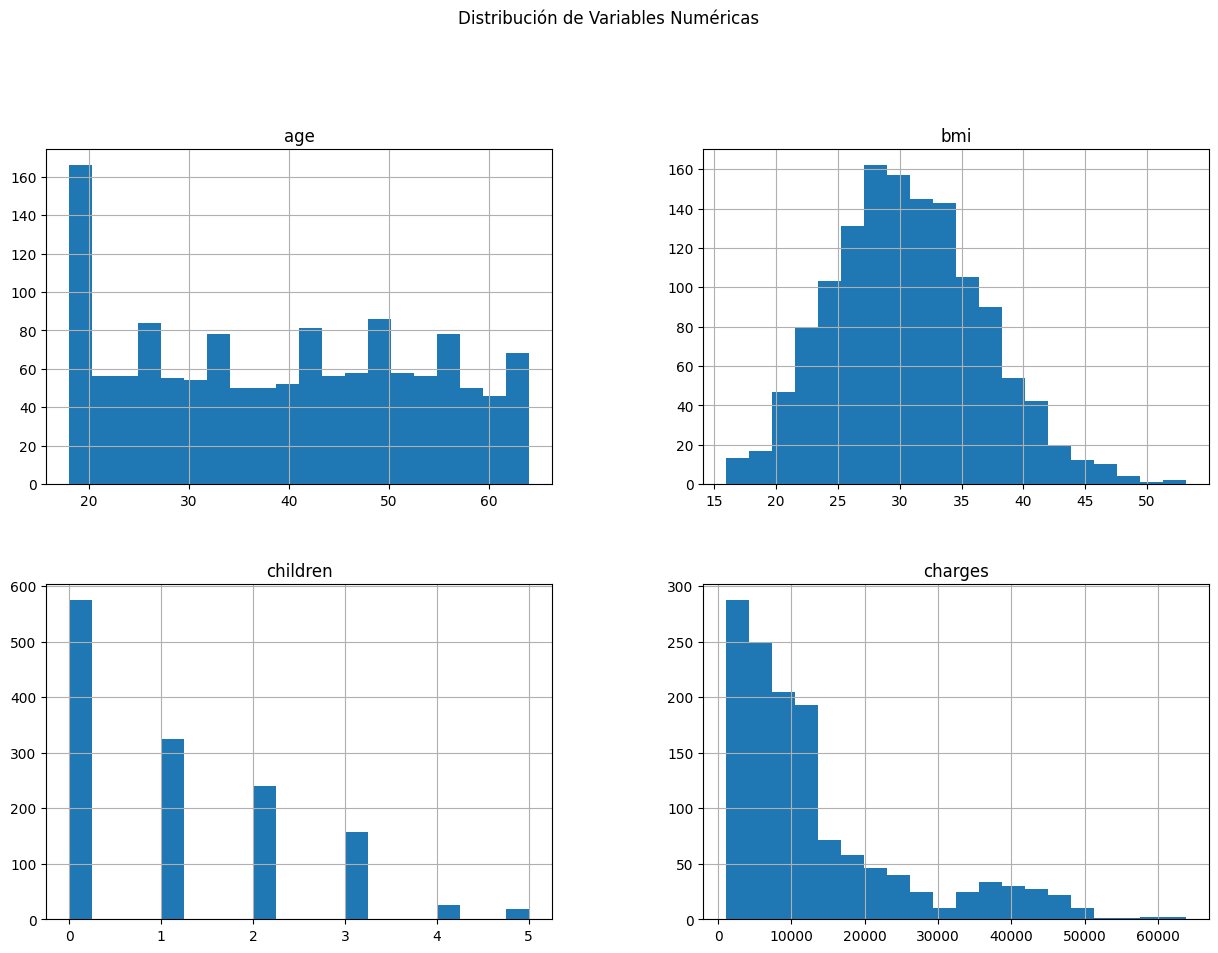

In [23]:
#Visualización de la distribución de las variables numéricas
numerical_cols = df.select_dtypes(include=np.number).columns
df[numerical_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle("Distribución de Variables Numéricas", y=1.02)
plt.show()

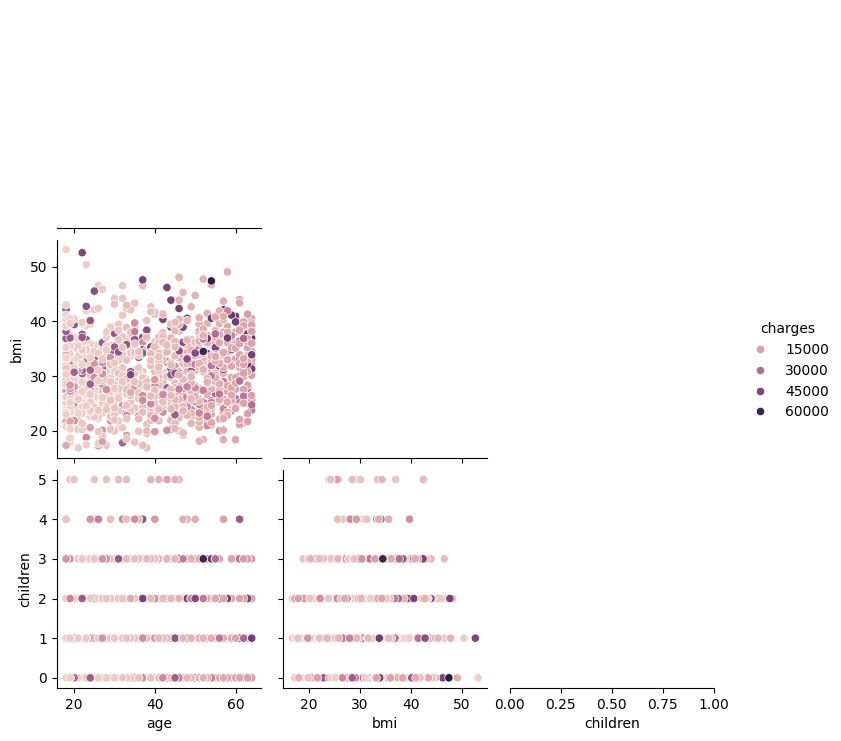

In [16]:
sns.pairplot(df_train, hue='charges', corner=True)
plt.show()

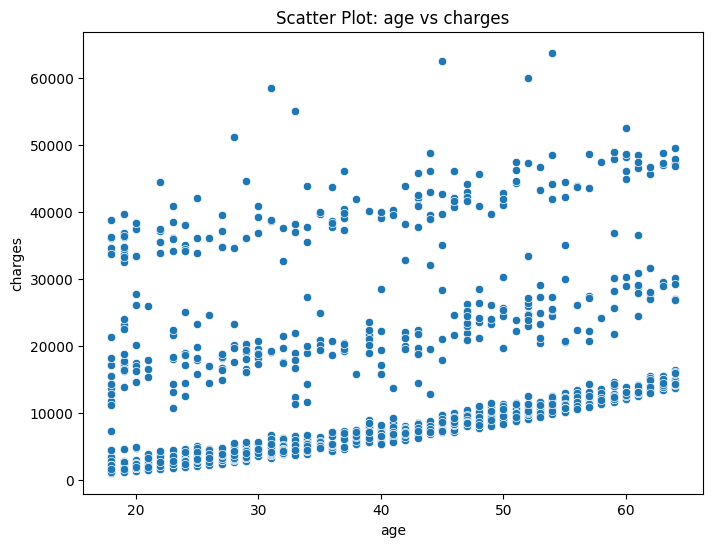

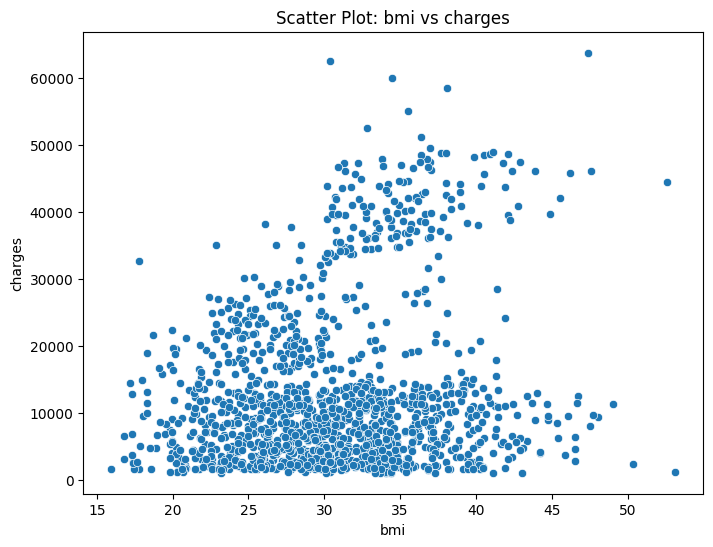

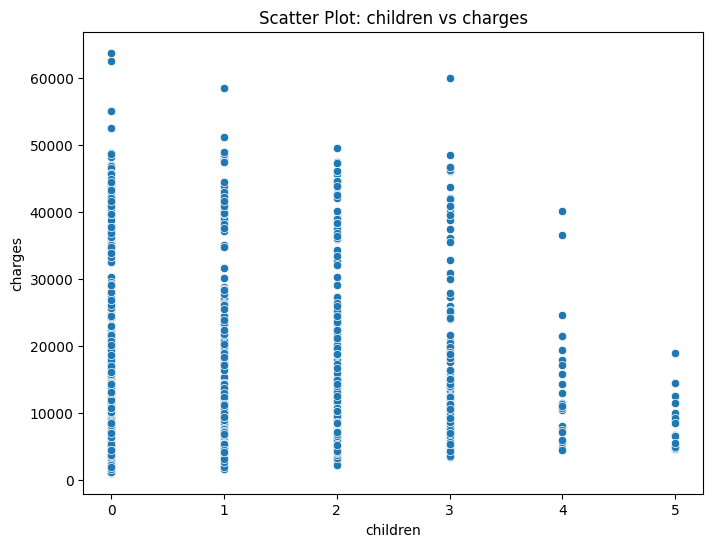

In [21]:
# e. Scatter plots de variables predictoras vs. variable objetivo (asumiendo la última columna es el objetivo)
if len(df.columns) > 1:
    target_column = df.columns[-1]
    predictor_columns = df.columns[:-1]
    for col in predictor_columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=df[col], y=df[target_column])
            plt.title(f"Scatter Plot: {col} vs {target_column}")
            plt.xlabel(col)
            plt.ylabel(target_column)
            plt.show()

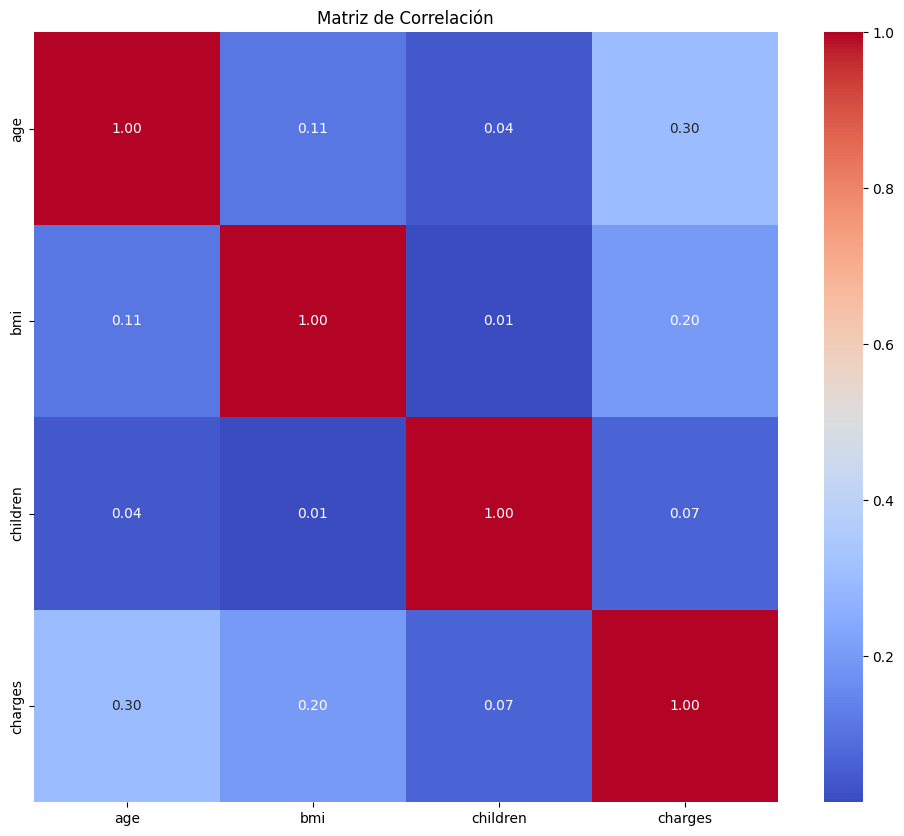

In [20]:
 # d. Matriz de correlación
correlation_matrix = df.corr(numeric_only=True) # Especificar solo columnas numéricas
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

### **4. Machine learning** **Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [9]:
# a. Identificar variables predictoras (X_train, X_test) y la variable objetivo (y_train, y_test)
X_train = df_train.drop('charges', axis=1)
y_train = df_train['charges']
X_test = df_test.drop('charges', axis=1)
y_test = df_test['charges']

# b. Identificar columnas categóricas y numéricas (basado en el conjunto de entrenamiento)
categorical_features = X_train.select_dtypes(include='category').columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

In [10]:
# c. Crear transformadores para variables numéricas y categóricas
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# d. Crear un preprocesador utilizando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
# e. Aplicar el preprocesador
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# f. Convertir los resultados procesados a DataFrames
X_train_processed_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

In [13]:
print("\n--- Entrenamiento del Modelo de Regresión Lineal ---")

# a. Crear el modelo de Regresión Lineal
linear_model = LinearRegression()

# b. Crear el pipeline de preprocesamiento y modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', linear_model)])

# c. Entrenar el modelo
pipeline.fit(X_train, y_train)


--- Entrenamiento del Modelo de Regresión Lineal ---


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['sex', 'smoker', 'region'], dtype='object'))])),
                ('regressor', LinearRegression())])


--- Evaluación del Modelo ---
Mean Squared Error (MSE): 38949557.16
R-squared (R2): 0.73


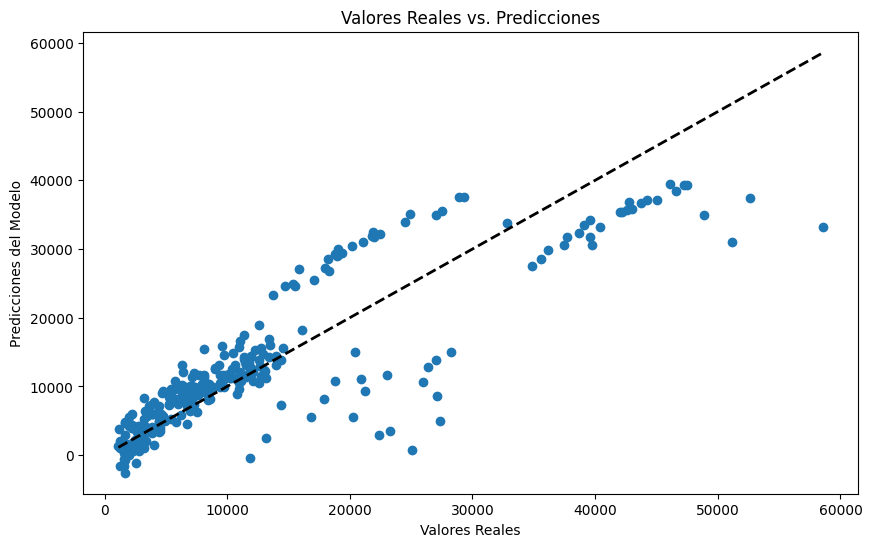

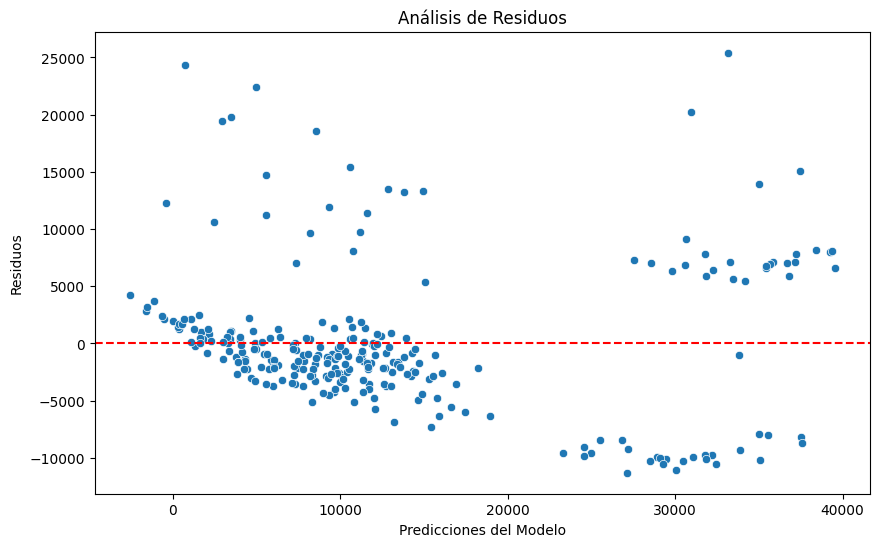

In [24]:
print("\n--- Evaluación del Modelo ---")

 # a. Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# b. Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# c. Visualización de las predicciones vs. valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones del Modelo")
plt.title("Valores Reales vs. Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Línea de predicción perfecta
plt.show()

# d. Análisis de los residuos
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicciones del Modelo")
plt.ylabel("Residuos")
plt.title("Análisis de Residuos")
plt.show()

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

In [28]:
# Pipeline con preprocesamiento y selección de las mejores k características
feature_selection_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('selector', SelectKBest(score_func=f_regression)),
                                     ('regressor', LinearRegression())])

# Definir el espacio de hiperparámetros para GridSearchCV
param_grid_fs = {
        'selector__k': range(1, X_train.shape[1] + 1) # Probar diferentes números de características
    }

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search_fs = GridSearchCV(feature_selection_pipeline, param_grid_fs, cv=5, scoring='neg_mean_squared_error')
grid_search_fs.fit(X_train, y_train)

print("Mejores hiperparámetros (Selección de Características):", grid_search_fs.best_params_)
best_model_fs = grid_search_fs.best_estimator_

# Evaluar el mejor modelo con selección de características
y_pred_fs = best_model_fs.predict(X_test)
mse_fs = mean_squared_error(y_test, y_pred_fs)
r2_fs = r2_score(y_test, y_pred_fs)
print(f"MSE (Selección de Características): {mse_fs:.2f}")
print(f"R2 (Selección de Características): {r2_fs:.2f}")

Mejores hiperparámetros (Selección de Características): {'selector__k': 5}
MSE (Selección de Características): 38659998.67
R2 (Selección de Características): 0.73


In [29]:
# Pipeline con preprocesamiento y regresión Ridge
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', Ridge())])

# Definir el espacio de hiperparámetros para GridSearchCV
param_grid_ridge = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100] # Diferentes valores de alpha (fuerza de regularización)
    }

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)

print("Mejores hiperparámetros (Ridge):", grid_search_ridge.best_params_)
best_model_ridge = grid_search_ridge.best_estimator_

# Evaluar el mejor modelo Ridge
y_pred_ridge = best_model_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"MSE (Ridge): {mse_ridge:.2f}")
print(f"R2 (Ridge): {r2_ridge:.2f}")

Mejores hiperparámetros (Ridge): {'regressor__alpha': 0.1}
MSE (Ridge): 38947855.69
R2 (Ridge): 0.73


In [32]:
# Pipeline con preprocesamiento y regresión Lasso
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Lasso())])

# Definir el espacio de hiperparámetros para GridSearchCV
param_grid_lasso = {
        'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100], # Diferentes valores de alpha
        'regressor__max_iter': [1000, 5000, 10000]
    }

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search_lasso = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, y_train)

print("Mejores hiperparámetros (Lasso):", grid_search_lasso.best_params_)
best_model_lasso = grid_search_lasso.best_estimator_

# Evaluar el mejor modelo Lasso
y_pred_lasso = best_model_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"MSE (Lasso): {mse_lasso:.2f}")
print(f"R2 (Lasso): {r2_lasso:.2f}")

/workspaces/linear_regresion/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.643e+08, tolerance: 1.218e+07
  model = cd_fast.enet_coordinate_descent(
/workspaces/linear_regresion/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.037e+09, tolerance: 1.254e+07
  model = cd_fast.enet_coordinate_descent(
/workspaces/linear_regresion/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Mejores hiperparámetros (Lasso): {'regressor__alpha': 10, 'regressor__max_iter': 1000}
MSE (Lasso): 38898671.64
R2 (Lasso): 0.73


In [33]:

print("\n--- Entrenamiento del Modelo Final (Selección de Características) ---")

# Re-crear el preprocesador (igual que antes)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Crear el pipeline con el preprocesador y el selector con el mejor 'k' encontrado
final_model_fs_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('selector', SelectKBest(score_func=f_regression, k=5)),
                                          ('regressor', LinearRegression())])

# Entrenar el modelo final en todo el conjunto de entrenamiento
final_model_fs_pipeline.fit(X_train, y_train)

# Evaluar el modelo final en el conjunto de prueba (opcional, ya lo hiciste durante la optimización)
y_pred_final_fs = final_model_fs_pipeline.predict(X_test)
mse_final_fs = mean_squared_error(y_test, y_pred_final_fs)
r2_final_fs = r2_score(y_test, y_pred_final_fs)
print(f"MSE del Modelo Final (Selección de Características): {mse_final_fs:.2f}")
print(f"R2 del Modelo Final (Selección de Características): {r2_final_fs:.2f}")


--- Entrenamiento del Modelo Final (Selección de Características) ---
MSE del Modelo Final (Selección de Características): 38659998.67
R2 del Modelo Final (Selección de Características): 0.73
